In [1]:
import numpy as np
import matplotlib.pyplot as plt
import find_alpha
import torch

Реализуем второй метод для нахождения оптимального $\alpha$: минимизация обобщённой невязки

С известной $\sigma$

In [2]:
f_0 = 300
mu = 8e5
a = 0
b = 1e-2
N = 100
t_ax = np.linspace(a,b,N)

x_t = lambda t : np.cos(2 * np.pi * f_0 * t + mu * t**2)

beta = 3e3
A = 0.5
dt = 2e-3

kernel = lambda t : np.exp(- beta * t) + A * np.exp(- beta * t - dt)

In [3]:
f_t = find_alpha.conv(kernel, x_t, t_ax)

In [4]:
#Фурье от правой части:
kernel_ar = kernel(t_ax)
kernel_fft = np.fft.fft(kernel_ar)
m_omega = lambda omega: omega ** 2 + 1e-4
freq_ax = np.fft.fftfreq(len(t_ax), t_ax[1] - t_ax[0])
m_ar = m_omega(freq_ax)

In [5]:
epoch_num = 1000
alpha_opt = np.zeros(epoch_num)

In [6]:
sig_1 = np.load('../30_9/sec_meth_1_e_1.npy')
sig_2 = np.load('../30_9/sec_meth_7_e_2_n.npy')

Text(0, 0.5, 'frequency')

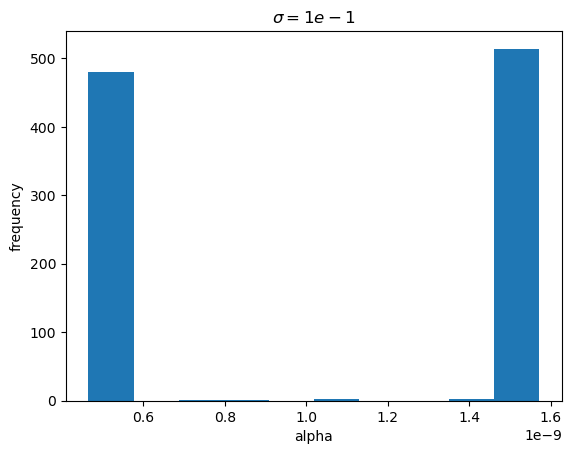

In [7]:
plt.hist(sig_1)
plt.title('$\sigma = 1e-1$')
plt.xlabel('alpha')
plt.ylabel('frequency')

Text(0, 0.5, 'frequency')

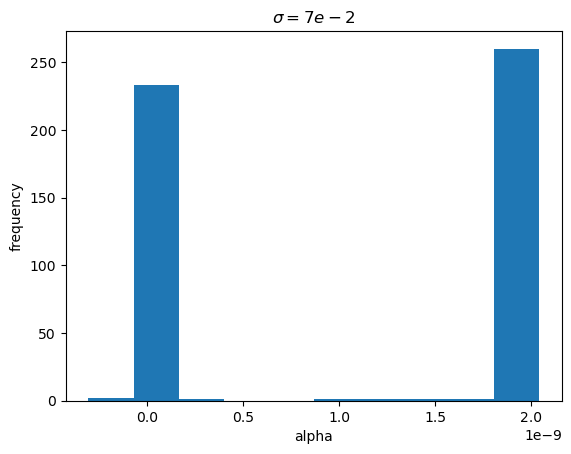

In [8]:
plt.hist(sig_2)
plt.title('$\sigma = 7e-2$')
plt.xlabel('alpha')
plt.ylabel('frequency')

Для $\sigma = 7e-2$ сместим оценку вверх и вниз на 20% и посмотрим на гистограммы частот

In [9]:
sig_high = np.load('../30_9/sec_meth_7_e_2_high.npy')
sig_low = np.load('../30_9/sec_meth_7_e_2_low.npy')

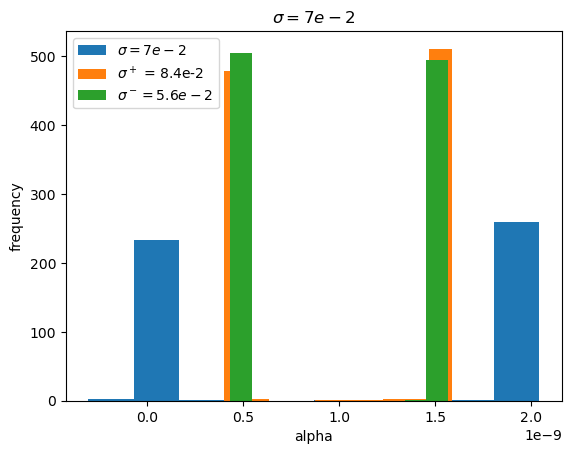

In [10]:
plt.hist(sig_2, label='$\sigma = 7e-2$')
plt.hist(sig_high, label='$\sigma^+$ = 8.4e-2')
plt.hist(sig_low, label='$\sigma^- = 5.6e-2$')
plt.title('$\sigma = 7e-2$')
plt.xlabel('alpha')
plt.ylabel('frequency')
plt.legend()

Построим график $||Ax_\alpha - f_\delta||^2 \left( ||x_\alpha||^2 \right)$

In [21]:
alpha_range = np.linspace(1e-11, 1e-8)
ax_ar = np.zeros(len(alpha_range))
x_alpha_ar = np.zeros(len(alpha_range))

In [22]:
noise = np.random.normal(0, 7e-2, len(kernel_fft))
right_noisy = f_t + noise
right_fft = np.fft.fft(right_noisy)

In [23]:
def conv(kernel, func):
    result = np.zeros(len(func))
    F = np.flip(func, 0)
    for i in range(len(func)):
        result[i] = np.sum(kernel * np.roll(F, i + 1))
    return result

In [24]:
for i in range(len(alpha_range)):
    x_alpha = find_alpha.fourier_solve(kernel_fft, right_fft, m_ar, alpha_range[i])
    x_alpha_ar[i] = np.linalg.norm(x_alpha) ** 2
    ax_ar[i] = np.linalg.norm(conv(kernel_ar, x_alpha) - right_noisy) ** 2

Text(0, 0.5, '$||Ax_\\alpha - f_\\delta||$')

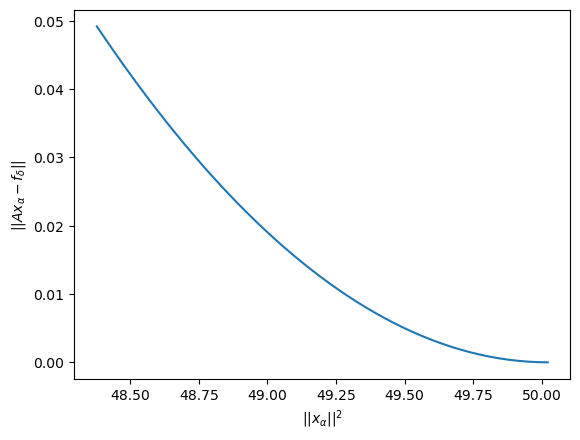

In [31]:
plt.plot(x_alpha_ar, ax_ar)
plt.xlabel(r'$||x_\alpha||^2$')
plt.ylabel(r'$||Ax_\alpha - f_\delta||$')

### Метод Райса

In [29]:
#пробный вариант:
alpha = 1e-9
x_a = find_alpha.fourier_solve(kernel_fft, right_fft, m_ar, alpha)
modulator = np.zeros(len(x_a))
for i in range(len(modulator) // 2):
    modulator[i] = 2
beta_a = np.fft.fft(x_a) * modulator
gamma_a = np.fft.ifft(beta_a)

z_t = np.abs(gamma_a)